In [48]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Combine Data Frames for SVM

In [49]:
# read in all files 

# reservoir data
res = pd.read_csv('reservoir_cleaned.csv')
# api data
api = pd.read_csv('weather_api_data.csv')
# surface temperature (surfTemp)
surfTemp = pd.read_csv('clean_surface_temp_data.csv')
# deep water temperature (deepTemp)
deepTemp = pd.read_csv('clean_deep_temp_data.csv')
# dissolved oxygen (do)
do = pd.read_csv('clean_DO_data.csv')
# cyanotaxa data (algae)
algae = pd.read_csv('clean_HAB_data.csv')

In [50]:
res = res.fillna('None') # fill NAs with none

In [51]:
# focus on 5 desired reservoirs for algae
algae = algae[(algae['reservoir'] == 'BHR') | (algae['reservoir'] == 'BRR') | (algae['reservoir'] == 'CBR') | (algae['reservoir'] == 'NRR') | (algae['reservoir'] == 'WFR')]
algae = algae.reset_index(drop = True) # reset index
algae = algae.drop('Unnamed: 0', axis = 1)

# focus on 5 desired reservoirs for surface water temperatures
surfTemp = surfTemp[(surfTemp['reservoir'] == 'BHR') | (surfTemp['reservoir'] == 'BRR') | (surfTemp['reservoir'] == 'CBR') | (surfTemp['reservoir'] == 'NRR') | (surfTemp['reservoir'] == 'WFR')]
surfTemp= surfTemp.reset_index(drop = True) # reset index
surfTemp = surfTemp.drop('Unnamed: 0', axis = 1)

# focus on 5 desired reservoirs for deepwater temperatures
deepTemp = deepTemp[(deepTemp['reservoir'] == 'BHR') | (deepTemp['reservoir'] == 'BRR') | (deepTemp['reservoir'] == 'CBR') | (deepTemp['reservoir'] == 'NRR') | (deepTemp['reservoir'] == 'WFR')]
deepTemp= deepTemp.reset_index(drop = True) # reset index
deepTemp = deepTemp.drop('Unnamed: 0', axis = 1)

# focus on 5 desired reservoirs for dissolved oxygen
do = do[(do['reservoir'] == 'BHR') | (do['reservoir'] == 'BRR') | (do['reservoir'] == 'CBR') | (do['reservoir'] == 'NRR') | (do['reservoir'] == 'WFR')]
do = do.reset_index(drop = True) # reset index
do = do.drop('Unnamed: 0', axis = 1)



In [52]:
# get monthly average for surface water temperature for every year
monthly_avg_ST = surfTemp.groupby(['reservoir', 'yearmonth'])['temperature'].mean()
monthly_avg_ST = pd.DataFrame(monthly_avg_ST).reset_index()
monthly_avg_ST.rename(columns = {'temperature':'m_avg_surf_temp'}, inplace = True)

# get monthly average for deep water temperature for every year
monthly_avg_DT = deepTemp.groupby(['reservoir', 'yearmonth'])['temperature'].mean()
monthly_avg_DT = pd.DataFrame(monthly_avg_DT).reset_index()
monthly_avg_DT.rename(columns = {'temperature':'m_avg_deep_temp'}, inplace = True)

# get monthly average for dissolved oxygen for every year
monthly_avg_DO = do.groupby(['reservoir', 'yearmonth'])['do'].mean()
monthly_avg_DO = pd.DataFrame(monthly_avg_DO).reset_index()
monthly_avg_DO.rename(columns = {'do':'m_avg_dissolved_oxygen'}, inplace = True)

# get monthly average for algal bloom density 
algae_monthly = algae.groupby(['reservoir', 'yearmonth'])['density_cells/ml'].mean()
algae_monthly = pd.DataFrame(algae_monthly).reset_index()


In [53]:
# merge average surface temps and average deep temp to one data frame
blooms = pd.merge(left=monthly_avg_ST, right=monthly_avg_DT, how='left', left_on=['reservoir', 'yearmonth'], right_on=['reservoir', 'yearmonth'])
median_DT = blooms['m_avg_deep_temp'].median()
blooms.fillna(median_DT, inplace = True)


In [54]:
# merge average DO to new data frame
blooms = pd.merge(left = blooms, right = monthly_avg_DO, how = 'left', left_on = ['reservoir', 'yearmonth'], right_on=['reservoir', 'yearmonth'])
median_DO = blooms['m_avg_dissolved_oxygen'].median()
blooms.fillna(median_DO, inplace = True)
blooms

,reservoir,yearmonth,m_avg_surf_temp,m_avg_deep_temp,m_avg_dissolved_oxygen
0,BHR,198905,18.660000,12.935897,8.492308
1,BHR,198906,24.787500,16.745000,7.085000
2,BHR,198907,27.100000,20.720690,3.751724
3,BHR,198908,26.840000,22.329730,0.800000
4,BHR,198909,24.314286,22.703333,1.960000
...,...,...,...,...,...
760,WFR,201806,30.400000,23.500000,0.120000
761,WFR,201807,26.450000,25.350000,0.150000
762,WFR,201808,24.700000,24.000000,1.045000
763,WFR,201809,29.260000,19.223810,1.781395


In [55]:
# merge algal bloom density to the blooms dataframe 
blooms = pd.merge(left = blooms, right = algae_monthly, how = 'left', left_on = ['reservoir', 'yearmonth'], right_on = ['reservoir', 'yearmonth'])
blooms['density_cells/ml'].fillna(0, inplace = True)
blooms.isnull().sum()
blooms

,reservoir,yearmonth,m_avg_surf_temp,m_avg_deep_temp,m_avg_dissolved_oxygen,density_cells/ml
0,BHR,198905,18.660000,12.935897,8.492308,0.000000
1,BHR,198906,24.787500,16.745000,7.085000,0.000000
2,BHR,198907,27.100000,20.720690,3.751724,0.000000
3,BHR,198908,26.840000,22.329730,0.800000,0.000000
4,BHR,198909,24.314286,22.703333,1.960000,0.000000
...,...,...,...,...,...,...
760,WFR,201806,30.400000,23.500000,0.120000,0.000000
761,WFR,201807,26.450000,25.350000,0.150000,0.000000
762,WFR,201808,24.700000,24.000000,1.045000,0.000000
763,WFR,201809,29.260000,19.223810,1.781395,85500.773955


In [56]:
# get yearly monthly averages for temperature, daylight duration, and precipitation from the api data
api_temp = api.groupby(['reservoir', 'yearmonth'])['temperature'].mean()
api_temp = pd.DataFrame(api_temp).reset_index()
api_daylight = api.groupby(['reservoir', 'yearmonth'])['daylight_duration'].mean()
api_daylight = pd.DataFrame(api_daylight).reset_index()
api_precipitation = api.groupby(['reservoir', 'yearmonth'])['precipitation_sum'].mean()
api_precipitation = pd.DataFrame(api_precipitation).reset_index()

In [57]:
# merge yearly monhtly averages for temperature, daylight duration, and precipitation with the algae monthly data 
blooms = pd.merge(blooms, api_temp, on=['reservoir', 'yearmonth'], how='left')
blooms = pd.merge(blooms, api_precipitation, on=['reservoir', 'yearmonth'], how='left')
blooms = pd.merge(blooms, api_daylight, on=['reservoir', 'yearmonth'], how='left')
blooms

,reservoir,yearmonth,m_avg_surf_temp,m_avg_deep_temp,m_avg_dissolved_oxygen,density_cells/ml,temperature,precipitation_sum,daylight_duration
0,BHR,198905,18.660000,12.935897,8.492308,0.000000,15.983871,4.054839,51084.427742
1,BHR,198906,24.787500,16.745000,7.085000,0.000000,21.860000,6.020000,52900.719333
2,BHR,198907,27.100000,20.720690,3.751724,0.000000,23.796774,5.000000,51972.881613
3,BHR,198908,26.840000,22.329730,0.800000,0.000000,23.106452,3.619355,48790.638387
4,BHR,198909,24.314286,22.703333,1.960000,0.000000,19.916667,5.473333,44665.057333
...,...,...,...,...,...,...,...,...,...
760,WFR,201806,30.400000,23.500000,0.120000,0.000000,23.493333,4.230000,53587.261000
761,WFR,201807,26.450000,25.350000,0.150000,0.000000,24.348387,3.564516,52590.467419
762,WFR,201808,24.700000,24.000000,1.045000,0.000000,23.890323,3.519355,49167.022258
763,WFR,201809,29.260000,19.223810,1.781395,85500.773955,21.560000,6.106667,44751.888000


In [58]:
# add the type, stratification, latitude, and longitude for each reservoir

# create empty lists
type = []
strat = []
lat = []
long = []

# create a for loop to run through the monthly algae data frame and add the appropriate values to each list
for i in range(len(blooms)):
    if blooms['reservoir'][i] == 'BHR': # check for BHR
        type.append(*res[res['reservoir_abbreviation'] == 'BHR']['type'])
        strat.append(*res[res['reservoir_abbreviation'] == 'BHR']['stratification'])
        lat.append(*res[res['reservoir_abbreviation'] == 'BHR']['latitude'])
        long.append(*res[res['reservoir_abbreviation'] == 'BHR']['longitude'])
    elif blooms['reservoir'][i] == 'BRR': # check for BRR
        type.append(*res[res['reservoir_abbreviation'] == 'BRR']['type'])
        strat.append(*res[res['reservoir_abbreviation'] == 'BRR']['stratification'])
        lat.append(*res[res['reservoir_abbreviation'] == 'BRR']['latitude'])
        long.append(*res[res['reservoir_abbreviation'] == 'BRR']['longitude'])
    elif blooms['reservoir'][i] == 'CBR': # check for CBR
        type.append(*res[res['reservoir_abbreviation'] == 'CBR']['type'])
        strat.append(*res[res['reservoir_abbreviation'] == 'CBR']['stratification'])
        lat.append(*res[res['reservoir_abbreviation'] == 'CBR']['latitude'])
        long.append(*res[res['reservoir_abbreviation'] == 'CBR']['longitude'])
    elif blooms['reservoir'][i] == 'NRR': # check for NRR
        type.append(*res[res['reservoir_abbreviation'] == 'NRR']['type'])
        strat.append(*res[res['reservoir_abbreviation'] == 'NRR']['stratification'])
        lat.append(*res[res['reservoir_abbreviation'] == 'NRR']['latitude'])
        long.append(*res[res['reservoir_abbreviation'] == 'NRR']['longitude'])
    elif blooms['reservoir'][i] == 'WFR': # check for WFR
        type.append(*res[res['reservoir_abbreviation'] == 'WFR']['type'])
        strat.append(*res[res['reservoir_abbreviation'] == 'WFR']['stratification'])
        lat.append(*res[res['reservoir_abbreviation'] == 'WFR']['latitude'])
        long.append(*res[res['reservoir_abbreviation'] == 'WFR']['longitude'])

# add the lists to the algae monthly data frame
blooms['type'] = type
blooms['stratification'] = strat
blooms['latitude'] = lat
blooms['longitude'] = long
blooms

,reservoir,yearmonth,m_avg_surf_temp,m_avg_deep_temp,m_avg_dissolved_oxygen,density_cells/ml,temperature,precipitation_sum,daylight_duration,type,stratification,latitude,longitude
0,BHR,198905,18.660000,12.935897,8.492308,0.000000,15.983871,4.054839,51084.427742,Forest,Strong,37.3386,-83.4707
1,BHR,198906,24.787500,16.745000,7.085000,0.000000,21.860000,6.020000,52900.719333,Forest,Strong,37.3386,-83.4707
2,BHR,198907,27.100000,20.720690,3.751724,0.000000,23.796774,5.000000,51972.881613,Forest,Strong,37.3386,-83.4707
3,BHR,198908,26.840000,22.329730,0.800000,0.000000,23.106452,3.619355,48790.638387,Forest,Strong,37.3386,-83.4707
4,BHR,198909,24.314286,22.703333,1.960000,0.000000,19.916667,5.473333,44665.057333,Forest,Strong,37.3386,-83.4707
...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,WFR,201806,30.400000,23.500000,0.120000,0.000000,23.493333,4.230000,53587.261000,Urban,None,39.2607,-84.4975
761,WFR,201807,26.450000,25.350000,0.150000,0.000000,24.348387,3.564516,52590.467419,Urban,None,39.2607,-84.4975
762,WFR,201808,24.700000,24.000000,1.045000,0.000000,23.890323,3.519355,49167.022258,Urban,None,39.2607,-84.4975
763,WFR,201809,29.260000,19.223810,1.781395,85500.773955,21.560000,6.106667,44751.888000,Urban,None,39.2607,-84.4975


In [59]:
# add labels for algae bloom or no algae bloom
alg_bloom = []
alg_bloom_num = []
for i in range(len(blooms)):
    if blooms['density_cells/ml'][i] > 0:
        alg_bloom.append("bloom")
        alg_bloom_num.append(1)
    else:
        alg_bloom.append("no bloom")
        alg_bloom_num.append(0)

blooms['alg_bloom'] = alg_bloom
blooms['alg_bloom_num'] = alg_bloom_num
blooms['temp_diff'] = blooms['m_avg_surf_temp'] - blooms['m_avg_deep_temp']
blooms

,reservoir,yearmonth,m_avg_surf_temp,m_avg_deep_temp,m_avg_dissolved_oxygen,density_cells/ml,temperature,precipitation_sum,daylight_duration,type,stratification,latitude,longitude,alg_bloom,alg_bloom_num,temp_diff
0,BHR,198905,18.660000,12.935897,8.492308,0.000000,15.983871,4.054839,51084.427742,Forest,Strong,37.3386,-83.4707,no bloom,0,5.724103
1,BHR,198906,24.787500,16.745000,7.085000,0.000000,21.860000,6.020000,52900.719333,Forest,Strong,37.3386,-83.4707,no bloom,0,8.042500
2,BHR,198907,27.100000,20.720690,3.751724,0.000000,23.796774,5.000000,51972.881613,Forest,Strong,37.3386,-83.4707,no bloom,0,6.379310
3,BHR,198908,26.840000,22.329730,0.800000,0.000000,23.106452,3.619355,48790.638387,Forest,Strong,37.3386,-83.4707,no bloom,0,4.510270
4,BHR,198909,24.314286,22.703333,1.960000,0.000000,19.916667,5.473333,44665.057333,Forest,Strong,37.3386,-83.4707,no bloom,0,1.610952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,WFR,201806,30.400000,23.500000,0.120000,0.000000,23.493333,4.230000,53587.261000,Urban,None,39.2607,-84.4975,no bloom,0,6.900000
761,WFR,201807,26.450000,25.350000,0.150000,0.000000,24.348387,3.564516,52590.467419,Urban,None,39.2607,-84.4975,no bloom,0,1.100000
762,WFR,201808,24.700000,24.000000,1.045000,0.000000,23.890323,3.519355,49167.022258,Urban,None,39.2607,-84.4975,no bloom,0,0.700000
763,WFR,201809,29.260000,19.223810,1.781395,85500.773955,21.560000,6.106667,44751.888000,Urban,None,39.2607,-84.4975,bloom,1,10.036190


In [60]:
# export monthly bloom data as csv
blooms.to_csv('bloom_monthly.csv')

### Train and Test Split

In [61]:
# create training and testing data
# split into predictors and class
y = blooms['alg_bloom_num'] # this is our class data
# get predictors. Note this is all but the first column
predictors1 = ['temp_diff', 'm_avg_dissolved_oxygen', 'temperature', 'precipitation_sum'] 
x = blooms[predictors1]

# use train_test_split to create the testing and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0) # complete a 70-30 split


In [62]:
x_train.head()

,temp_diff,m_avg_dissolved_oxygen,temperature,precipitation_sum
553,4.819643,0.569365,21.896667,1.383333
533,15.633171,1.163415,25.751613,3.474194
761,1.100000,0.150000,24.348387,3.564516
737,-0.200000,1.781395,14.819355,0.522581
613,7.286667,0.566667,25.919355,4.177419


In [63]:
x_test.head()

,temp_diff,m_avg_dissolved_oxygen,temperature,precipitation_sum
733,1.275000,1.781395,24.296667,3.373333
122,4.300000,1.233750,22.816129,3.719355
113,2.913462,6.160000,17.035484,3.409677
14,4.827586,3.179310,25.238710,2.670968
271,5.052778,4.473333,18.896774,5.925806


In [64]:
y_train.head()

553    0
533    0
761    0
737    0
613    0
Name: alg_bloom_num, dtype: int64

In [65]:
y_test.head()

733    0
122    0
113    0
14     0
271    0
Name: alg_bloom_num, dtype: int64

In [66]:
# create train_test split with 2 predictors for visualization
# split into predictors and class
y2 = blooms['alg_bloom_num'] # this is our class data
# get predictors. Note this is all but the first column
predictors2 = ['temp_diff', 'm_avg_dissolved_oxygen'] 
x2 = blooms[predictors2]

# use train_test_split to create the testing and training data
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.3, random_state=0) # complete a 70-30 split


In [67]:
y2_test.head()

733    0
122    0
113    0
14     0
271    0
Name: alg_bloom_num, dtype: int64

In [78]:
y2_test.to_csv('svm_y2_test.csv')

## Run SVM 
Use the data to determine if there will be a bloom or no bloom 

### Kernel 1: RBF

#### C1 = 1

In [21]:
#create a svm classifier with the linear kernel and C = 1
clf = svm.SVC(C = 1, kernel='rbf', class_weight = {1:3}) 

#train the model
clf.fit(x_train, y_train)

#predict the response for test dataset
y_pred = clf.predict(x_test)

In [22]:
print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum())) 

Model accuracy score: 53.91%
Number of mislabeled points out of a total 230 points : 106


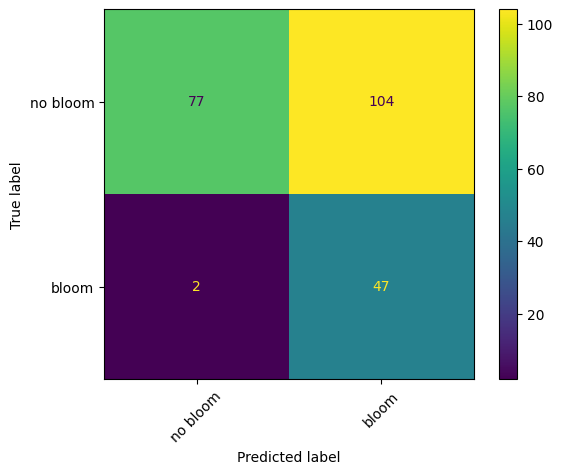

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)

#### C2 = 2

In [24]:
#Create a svm Classifier
clf = svm.SVC(C = 2, kernel='rbf', class_weight = {1:3}) # Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum())) 

Model accuracy score: 54.78%
Number of mislabeled points out of a total 230 points : 104


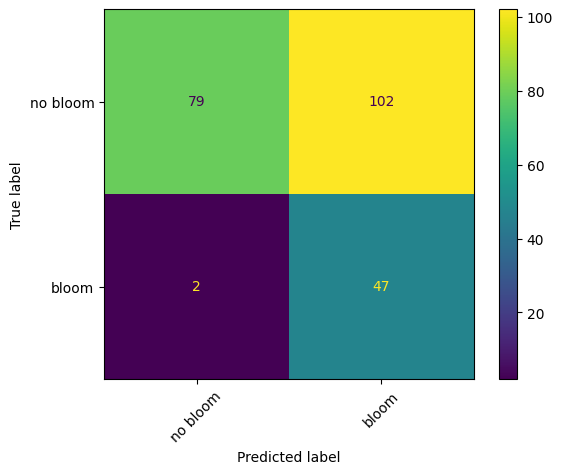

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)

#### C3 = 0.5

In [26]:
#Create a svm Classifier
clf = svm.SVC(C = 0.5, kernel='rbf', class_weight = {1:3}) # Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum())) 

Model accuracy score: 54.35%
Number of mislabeled points out of a total 230 points : 105


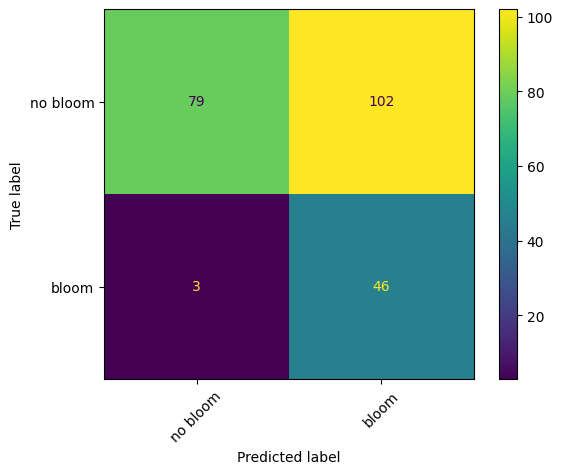

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)

### Kernel 2: Polynomial

#### C1 = 1

In [28]:
# create SVM classified with polynomial kernel
clf = svm.SVC(C = 1, kernel='poly', class_weight = {1:3}) 

# create svm model with training data
clf.fit(x_train, y_train)

# predict the response with testing data
y_pred = clf.predict(x_test)

# Get model accuracy
print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum()))

Model accuracy score: 61.74%
Number of mislabeled points out of a total 230 points : 88


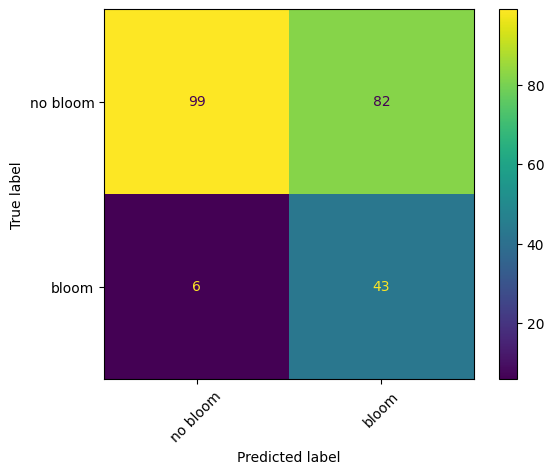

In [29]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)

#### C2 = 2

In [30]:
# create SVM classified with polynomial kernel
clf = svm.SVC(C = 2, kernel='poly', class_weight = {1:3}) 

# create svm model with training data
clf.fit(x_train, y_train)

# predict the response with testing data
y_pred = clf.predict(x_test)

# Get model accuracy
print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum()))

Model accuracy score: 60.00%
Number of mislabeled points out of a total 230 points : 92


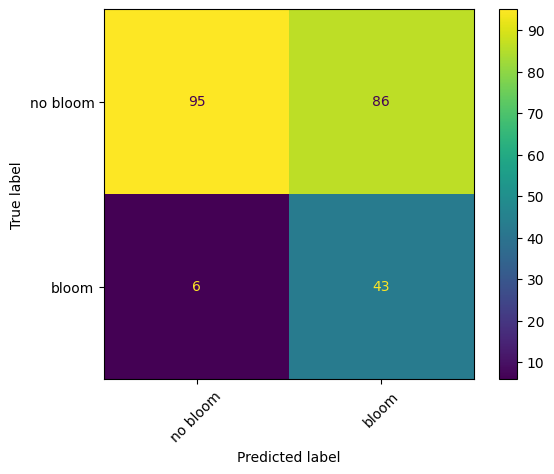

In [31]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)

 #### C3 = 0.5

In [32]:
# create SVM classified with polynomial kernel
clf = svm.SVC(C = 0.5, kernel='poly', class_weight = {1:3}) 

# create svm model with training data
clf.fit(x_train, y_train)

# predict the response with testing data
y_pred = clf.predict(x_test)

# Get model accuracy
print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum()))

Model accuracy score: 61.30%
Number of mislabeled points out of a total 230 points : 89


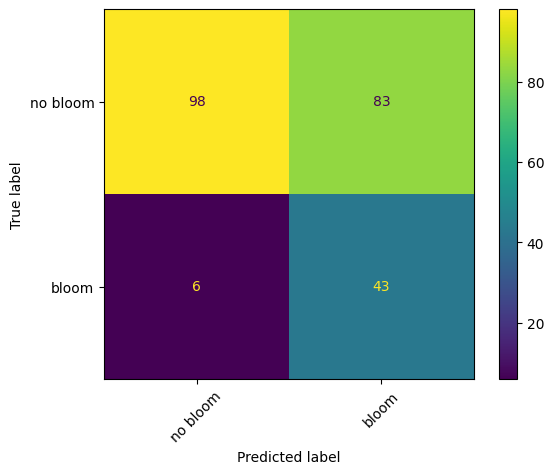

In [33]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)

In [34]:
# for visualization
# create SVM classified with polynomial kernel
clf = svm.SVC(C = 1, kernel='poly', class_weight = {1:3}) 

# create svm model with training data
clf.fit(x2_train, y2_train)

# predict the response with testing data
y2_pred = clf.predict(x2_test)

# Get model accuracy
print(f'Model accuracy score: {100*metrics.accuracy_score(y2_test, y2_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x2_test.shape[0], (y2_test != y2_pred).sum()))

Model accuracy score: 73.48%
Number of mislabeled points out of a total 230 points : 61


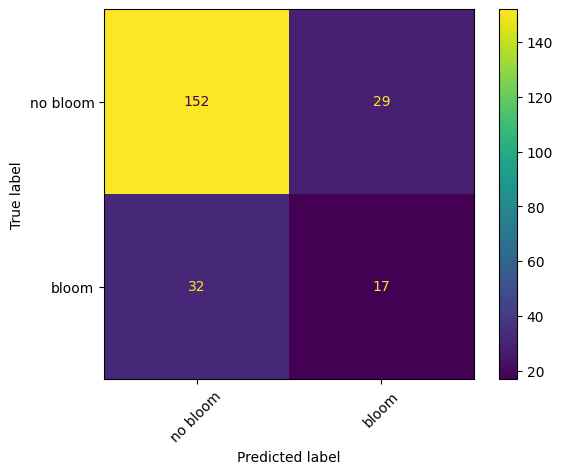

In [35]:
cm = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)

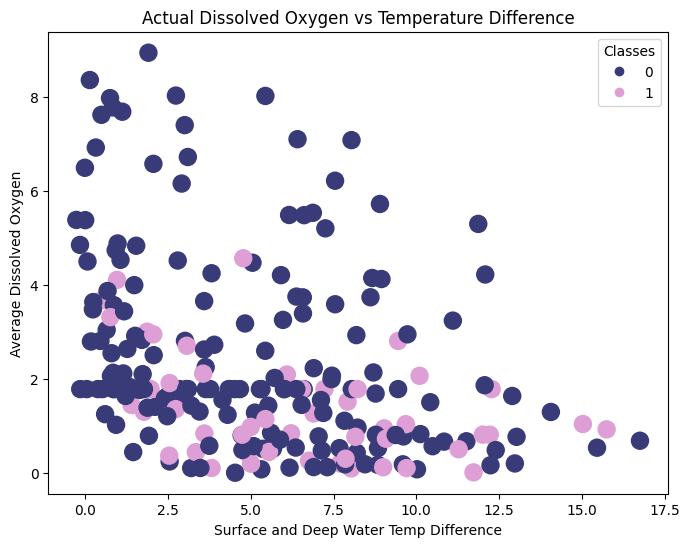

In [47]:
# plot the classification
# create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot samples by color and add legend
scatter = ax.scatter(x2_test['temp_diff'], x2_test['m_avg_dissolved_oxygen'], s=150, c=y2_test, label=y2_test, cmap = 'tab20b')
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.set_title("Actual Dissolved Oxygen vs Temperature Difference")
ax.set_xlabel("Surface and Deep Water Temp Difference")
ax.set_ylabel("Average Dissolved Oxygen")
_ = plt.show()


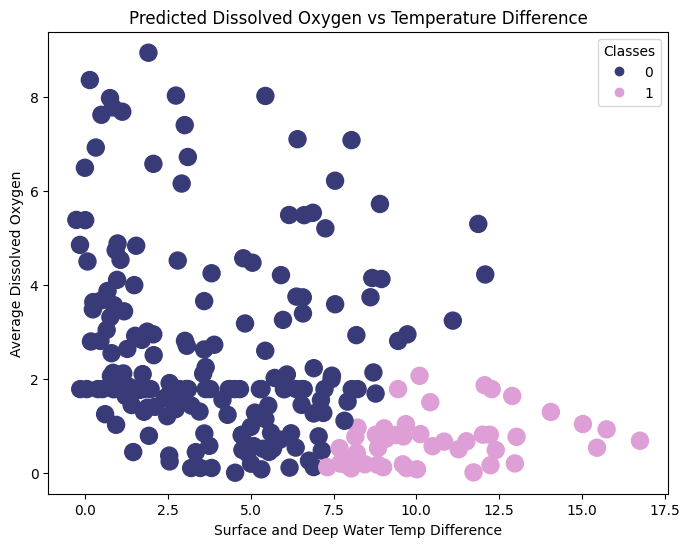

In [37]:
# plot the classification
# create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot samples by color and add legend
scatter = ax.scatter(x2_test['temp_diff'], x2_test['m_avg_dissolved_oxygen'], s=150, c=y2_pred, label=y2_pred, cmap = 'tab20b')
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.set_title("Predicted Dissolved Oxygen vs Temperature Difference")
ax.set_xlabel("Surface and Deep Water Temp Difference")
ax.set_ylabel("Average Dissolved Oxygen")
_ = plt.show()

### Kernel 3: Sigmoid

#### C1 = 1

In [38]:
# create svm classifier with sigmoid kernel
clf = svm.SVC(C = 1, kernel='sigmoid', class_weight = {1:3}) # rbf Kernel

# train svm with training and testing data
clf.fit(x_train, y_train)

# predict the response
y_pred = clf.predict(x_test)

# Get model accuracy
print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum()))

Model accuracy score: 38.26%
Number of mislabeled points out of a total 230 points : 142


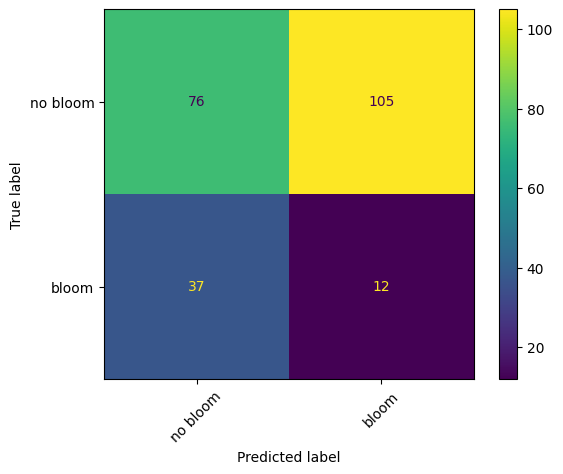

In [39]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)

#### C2 = 2

In [40]:
# create svm classifier with sigmoid kernel
clf = svm.SVC(C = 2, kernel='sigmoid', class_weight = {1:3}) # rbf Kernel

# train svm with training and testing data
clf.fit(x_train, y_train)

# predict the response
y_pred = clf.predict(x_test)

# Get model accuracy
print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum()))

Model accuracy score: 38.26%
Number of mislabeled points out of a total 230 points : 142


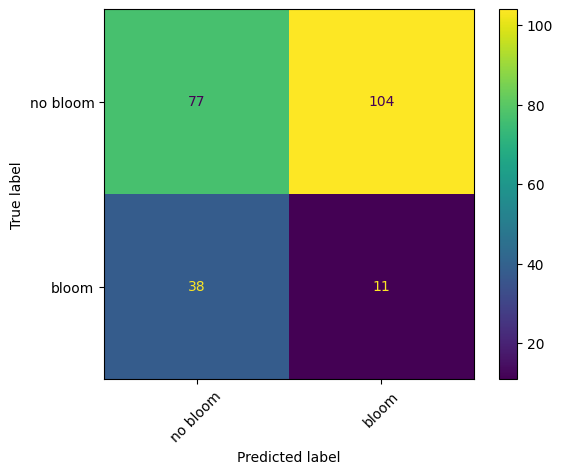

In [41]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)

#### C3 = 0.5

In [42]:
# create svm classifier with sigmoid kernel
clf = svm.SVC(C = 0.5, kernel='sigmoid', class_weight = {1:3}) # rbf Kernel

# train svm with training and testing data
clf.fit(x_train, y_train)

# predict the response
y_pred = clf.predict(x_test)

# Get model accuracy
print(f'Model accuracy score: {100*metrics.accuracy_score(y_test, y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test.shape[0], (y_test != y_pred).sum()))

Model accuracy score: 38.26%
Number of mislabeled points out of a total 230 points : 142


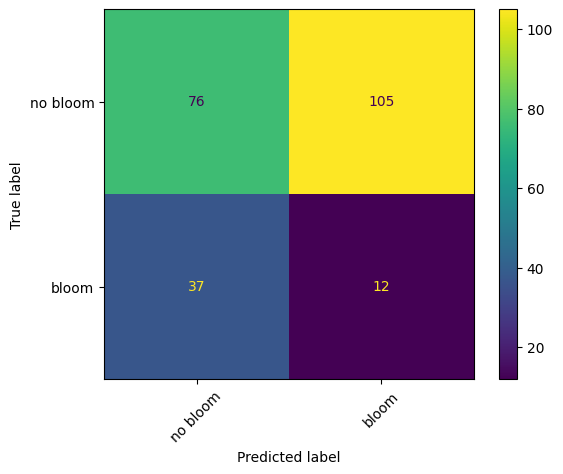

In [43]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['no bloom', 'bloom'])
disp.plot(xticks_rotation=45)